<a href="https://colab.research.google.com/github/Prax0028/Violence_Detection_Model_Codes/blob/main/ProjectV5_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection Using CNN (CNN/LSTM) and XAI

In [ ]:
!git clone https://github.com/Prax0028/violence_dataset

Cloning into 'violence_dataset'...
remote: Enumerating objects: 10971, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 10971 (delta 7), reused 0 (delta 0), pack-reused 10956 (from 1)
Receiving objects: 100% (10971/10971), 645.81 MiB | 42.21 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (11065/11065), done.


In [ ]:
!pip install -U albumentations==1.2.1

In [ ]:
!pip install --upgrade opencv-contrib-python

# Imports

In [ ]:
import sys
sys.path.append('/content/violence_dataset')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE = "/content/violence_dataset/image_labels.csv"
DATA_DIR = "/content/violence_dataset/"

DEVICE = 'cuda'

BATCH_SIZE = 4
LR = 0.001
EPOCHS = 20

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

img_path  label
0   non_violence/NV_1.mp4_frame0.jpg      0
1   non_violence/NV_1.mp4_frame1.jpg      0
2   non_violence/NV_1.mp4_frame2.jpg      0
3  non_violence/NV_10.mp4_frame0.jpg      0
4  non_violence/NV_10.mp4_frame1.jpg      0

In [ ]:
# non_violence-0, violence-1
train_df, valid_df = train_test_split(data,test_size = 0.15,random_state = 42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.Resize(224, 224),
    A.Rotate() ,
    A.HorizontalFlip(p=0.5),
    A. VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225])
])

valid_augs =  A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean = [0.485,0.456,0.406], std = [0.229,0.224,0.225])
])

# Load Image Dataset

In [ ]:
trainset = utils.ImageDataset(train_df,augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df,augs = valid_augs, data_dir = DATA_DIR)

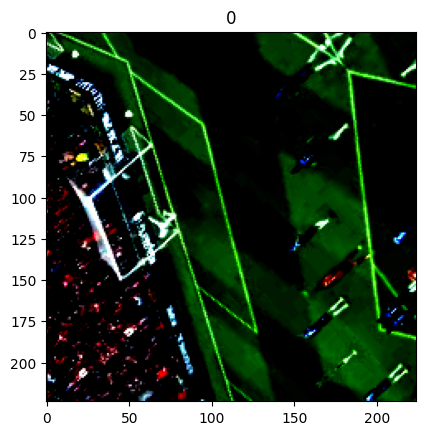

In [ ]:
image, label = trainset[0] #(c,h,w) -> (h,w,c)
class_list = ['non-violence','violence']

plt.imshow(image.permute(1,2,0))
plt.title(label);

In [ ]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 9403
No. of examples in the 1660


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 2351
No. of batches in validloader : 415


In [ ]:
for images,labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([4, 3, 224, 224])
One batch label shape : torch.Size([4])


# PyTorch Implementation

## Create Model

### CNN

In [ ]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

    self.avgpool =  nn.AdaptiveAvgPool2d((4, 4))  # Global average pooling to reduce spatial dimensions to 1x1
    self.classifier = nn.Sequential(
            nn.Flatten(),  # Flatten the feature maps into a 1D vector
            nn.Linear(128*4*4, 512),  # Assuming input size is (128, 128, 3), output after conv layers will be (128, 16, 16)
            nn.ReLU(),
            nn.Linear(512, 2)  # Output layer with 2 units (for 'violence' and 'non-violence')
    )

    self.gradient = None


  def forward(self,images):

    x = self.feature_extractor(images) #activation_maps
    h = x.register_hook(self.activations_hook)
    x = self.avgpool(x)
    x = self.classifier(x)

    return x


  def activations_hook(self,grad):
    self.gradient = grad

  def get_activation_gradients(self): #a1,a2,a3...ak
    return self.gradient

  def get_activation(self,x): #activation A1,A2,A3...Ak
    return self.feature_extractor(x) #64 * 8 * 8


In [ ]:
import torch
import torch.nn as nn

class CNNModelOptimizedMaxPool(nn.Module):
    def __init__(self):
        super(CNNModelOptimizedMaxPool, self).__init__()

        # Feature extraction layers with reduced filters
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Reduced filters from 32 to 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Reduced filters from 64 to 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Reduced filters from 128 to 64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier with flattened output
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),  # Reduced fully connected layer size
            nn.ReLU(),
            nn.Linear(512, 2)              # Output layer with 2 classes
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x

    def activations_hook(self,grad):
      self.gradient = grad

    def get_activation_gradients(self): #a1,a2,a3...ak
      return self.gradient

    def get_activation(self,x): #activation A1,A2,A3...Ak
      return self.feature_extractor(x) #64 * 8 * 8


In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CNNModel()
model.to(DEVICE)

CNNModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [ ]:
import torch.nn as nn

In [ ]:
class CNNModelWithLSTM(nn.Module):
    def __init__(self):
        super(CNNModelWithLSTM, self).__init__()

        # Feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

        # Adaptive average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((4, 4))

        # LSTM layer (input size = 128 * 4 = 512, hidden size = 256)
        self.lstm = nn.LSTM(input_size=128 * 4, hidden_size=256, num_layers=1, batch_first=True)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.feature_extractor(x)                # Extract features
        x = self.global_avg_pool(x)                 # Pool features
        x = x.view(x.size(0), 4, -1)                # Reshape for LSTM: (batch, sequence_length, input_size)
        _, (hidden, _) = self.lstm(x)               # LSTM output (use hidden state)
        x = hidden[-1]                              # Take the last layer's hidden state
        x = self.classifier(x)                      # Classify
        return x

In [ ]:
model = CNNModelWithLSTM()
model.to('cpu')

CNNModelWithLSTM(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (lstm): LSTM(512, 256, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)

## Create Train and Eval function

In [ ]:
# Function to train the model
def train_fun(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterate over batches
    for images, labels in tqdm(dataloader):
        # Move data to the specified DEVICE (e.g., GPU or CPU)
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        logits = model(images)

        # Calculate loss
        loss = criterion(logits, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()

        # Calculate predictions and accuracy
        predictions = torch.argmax(logits, dim=1)  # Assuming logits have shape (batch_size, num_classes)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

In [ ]:
# Function to evaluate the model
def eval_fun(dataloader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    all_actual_labels = []
    all_predicted_labels = []

    # Turn off gradients for validation to save memory and computations
    for images, labels in tqdm(dataloader):
            # Move data to the specified DEVICE (e.g., GPU or CPU)
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            logits = model(images)

            # Calculate loss
            loss = criterion(logits, labels)

            # Accumulate loss
            total_loss += loss.item()

            # Calculate predictions and accuracy
            predictions = torch.argmax(logits, dim=1)  # Assuming logits have shape (batch_size, num_classes)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            # Collect all actual and predicted labels
            all_actual_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

    # Calculate average loss and accuracy for the evaluation
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy, all_actual_labels, all_predicted_labels


## Training Loop

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=LR)
criterion = nn.CrossEntropyLoss()

In [ ]:
for image,label in tqdm(trainloader):
  print(image.size())
  break

  0%|          | 0/2351 [00:00<?, ?it/s]

torch.Size([4, 3, 224, 224])


In [ ]:
best_valid_loss = np.Inf

for epoch in range(5):

    # Training step
    train_loss, train_accuracy = train_fun(trainloader, model, optimizer, criterion)

    # Evaluation step
    valid_loss, valid_accuracy, all_actual_labels, all_predicted_labels = eval_fun(validloader, model, criterion)

    # Save the best model based on validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

        # Save model and optimizer state
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_valid_loss': best_valid_loss
        }, 'best_model.pth')

        print("Model saved successfully!")

    # Print epoch results
    print(f"EPOCH : {epoch+1}, TRAIN_LOSS : {train_loss:.4f}, TRAIN_ACCURACY: {train_accuracy:.4f}, VALID_LOSS : {valid_loss:.4f}, VALID_ACCURACY: {valid_accuracy:.4f}")


100%|██████████| 415/415 [00:07<00:00, 58.34it/s]


Model saved successfully!
EPOCH : 1, TRAIN_LOSS : 0.6208, TRAIN_ACCURACY: 0.6551, VALID_LOSS : 0.4966, VALID_ACCURACY: 0.7572


100%|██████████| 415/415 [00:07<00:00, 59.10it/s]


Model saved successfully!
EPOCH : 2, TRAIN_LOSS : 0.5084, TRAIN_ACCURACY: 0.7531, VALID_LOSS : 0.4220, VALID_ACCURACY: 0.8042


100%|██████████| 415/415 [00:06<00:00, 60.44it/s]


Model saved successfully!
EPOCH : 3, TRAIN_LOSS : 0.4500, TRAIN_ACCURACY: 0.7861, VALID_LOSS : 0.3587, VALID_ACCURACY: 0.8422


100%|██████████| 415/415 [00:06<00:00, 65.23it/s]


Model saved successfully!
EPOCH : 4, TRAIN_LOSS : 0.4142, TRAIN_ACCURACY: 0.8104, VALID_LOSS : 0.3276, VALID_ACCURACY: 0.8500


100%|██████████| 415/415 [00:07<00:00, 58.26it/s]

Model saved successfully!
EPOCH : 5, TRAIN_LOSS : 0.3699, TRAIN_ACCURACY: 0.8330, VALID_LOSS : 0.3156, VALID_ACCURACY: 0.8753


## Get GradCAM

In [ ]:
def get_gradcam(model, image, size):
    # Get the model's prediction
    pred = model(image)
    predicted_class = pred.argmax(dim=1)

    # Perform backpropagation on the predicted class
    model.zero_grad()
    pred[0][predicted_class].backward()

    # Get gradients of the predicted class
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Get the activations of the last convolutional layer
    activations = model.get_activation(image).detach()

    # Weight each channel by the corresponding gradient
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Compute the average across all channels to get the heatmap
    heatmap = torch.mean(activations, dim=1).squeeze().cpu()

    # Apply ReLU to keep only positive contributions
    heatmap = nn.ReLU()(heatmap)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.numpy()

    # Resize the heatmap to the size of the input image
    heatmap = cv2.resize(heatmap, (size, size))

    return heatmap


In [ ]:
def plot_heatmap(denorm_image, pred, heatmap, actual_label):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 20), ncols=3)

    classes = ['non-violence', 'violence']
    ps = torch.nn.Softmax(dim=1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)

    # Plot probabilities as bar chart
    ax2.barh(classes, ps[0])
    predicted_class_index = np.argmax(ps[0])
    predicted_class_label = classes[predicted_class_index]

    # Get the actual class label from the classes list
    actual_class_label = classes[actual_label]

    # Add a caption below the bar chart indicating the predicted class and actual class
    caption = (f"Predicted Class: {predicted_class_label} ({ps[0][predicted_class_index]:.2f} probability)\n"
               f"Actual Class: {actual_class_label}")
    ax2.text(0.5, -0.2, caption, ha='center', va='top', transform=ax2.transAxes, fontsize=12)

    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(classes)))
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='jet', alpha=0.7)

    plt.show()


In [ ]:
from sklearn.metrics import classification_report

def generate_classification_report(actual_labels, predicted_labels, classes):
    """
    Generate a classification report comparing actual labels with predicted labels.

    Parameters:
    - actual_labels (list or array): The ground truth labels.
    - predicted_labels (list or array): The predicted labels from the model.
    - classes (list): List of class names.

    Returns:
    - report (str): The classification report as a string.
    """
    # Generate the classification report
    report = classification_report(actual_labels, predicted_labels, target_names=classes)

    # Print the classification report
    print("Classification Report:")
    print(report)

    return report


In [ ]:
# Assuming you have lists of actual and predicted labels
actual_labels = []
predicted_labels = []

# Get predictions for the entire validation dataset
model.eval()  # Set model to evaluation mode

for images, labels in tqdm(validloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)

        # Append actual and predicted labels to respective lists
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# List of class names
classes = ['non-violence', 'violence']

# Generate classification report
generate_classification_report(actual_labels, predicted_labels, classes)


100%|██████████| 415/415 [00:06<00:00, 59.65it/s]

Classification Report:
              precision    recall  f1-score   support

non-violence       0.92      0.82      0.87       826
    violence       0.84      0.93      0.88       834

    accuracy                           0.88      1660
   macro avg       0.88      0.88      0.87      1660
weighted avg       0.88      0.88      0.87      1660



'              precision    recall  f1-score   support\n\nnon-violence       0.92      0.82      0.87       826\n    violence       0.84      0.93      0.88       834\n\n    accuracy                           0.88      1660\n   macro avg       0.88      0.88      0.87      1660\nweighted avg       0.88      0.88      0.87      1660\n'

## Output

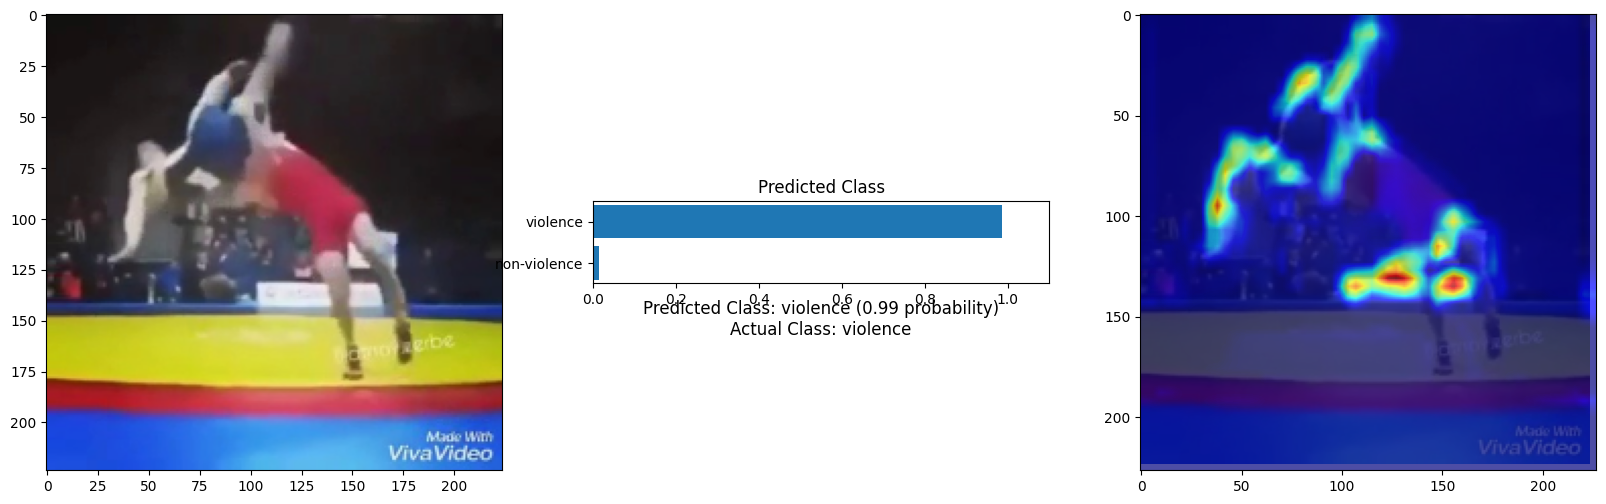

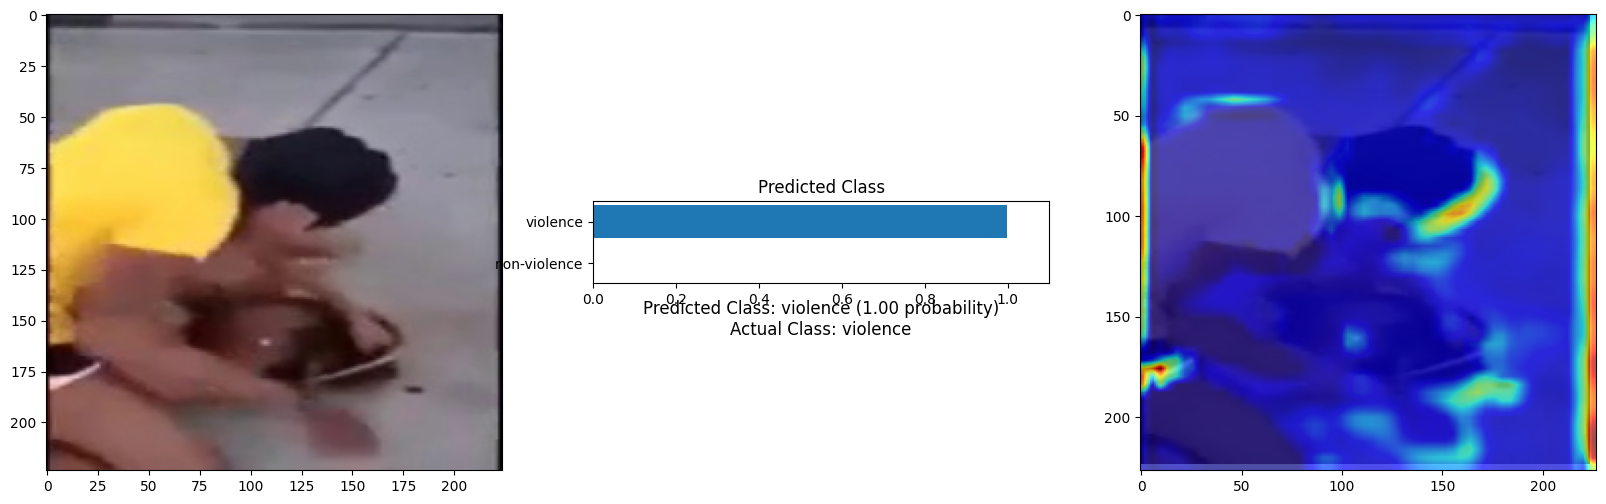

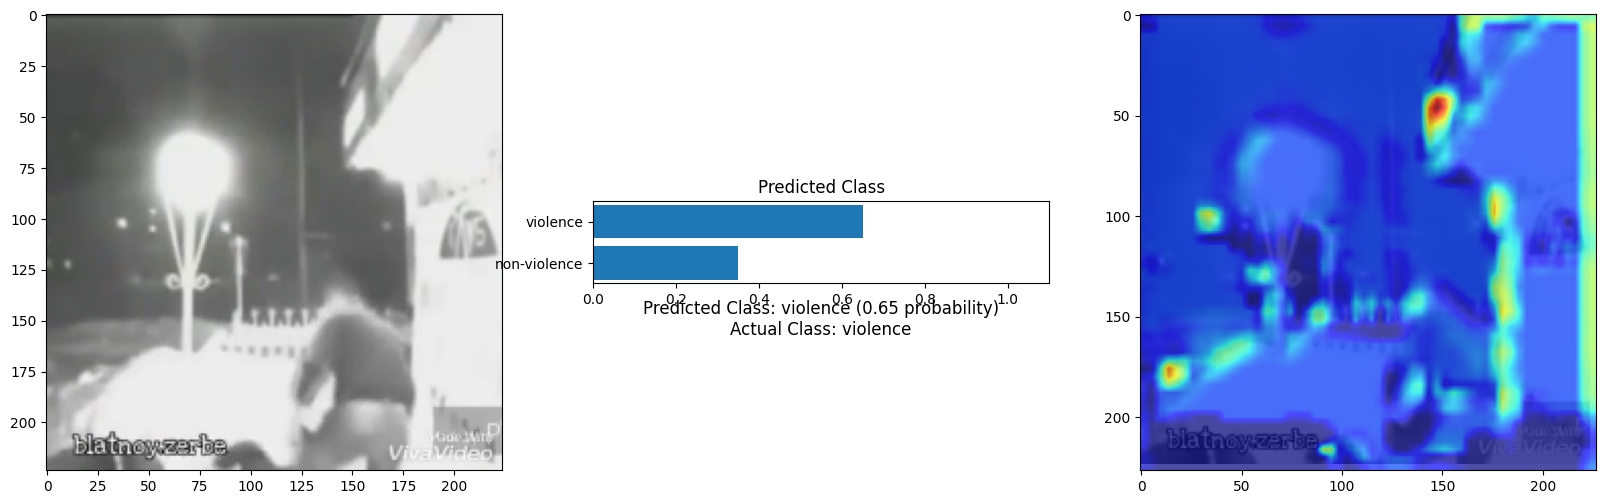

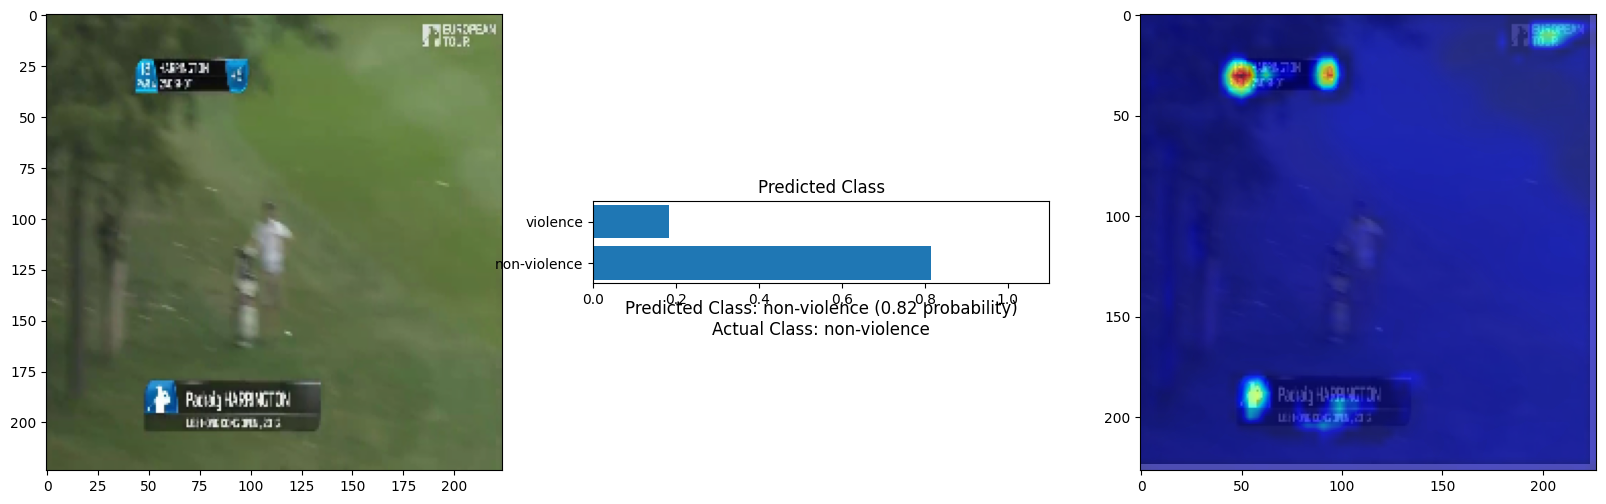

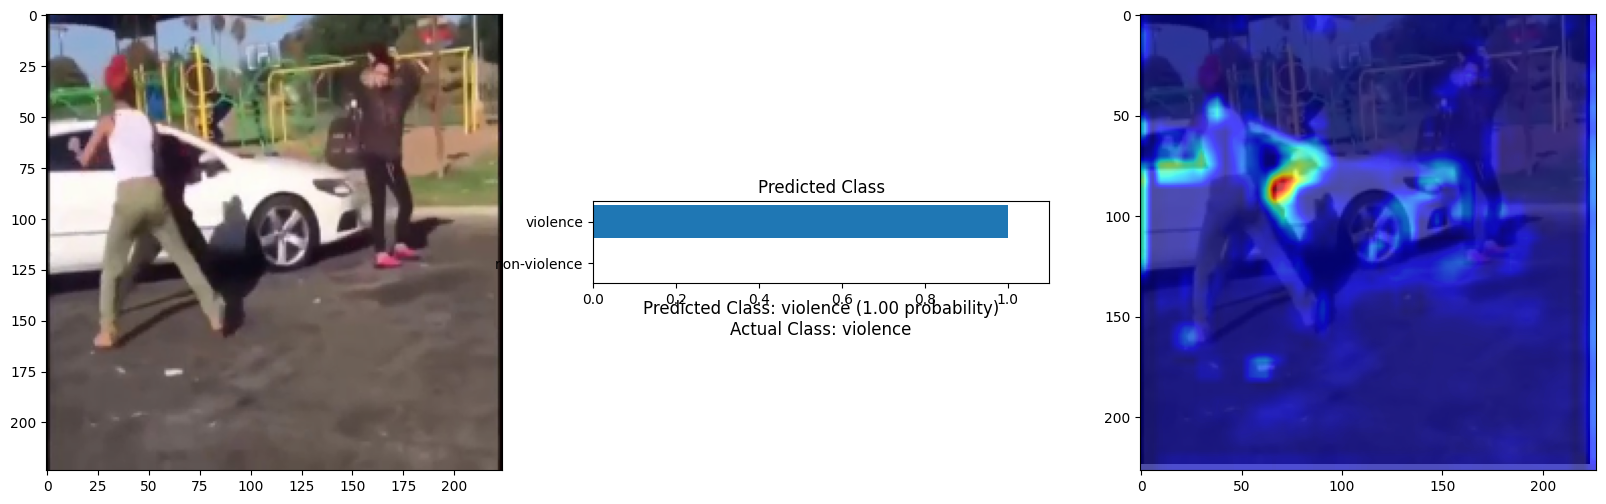

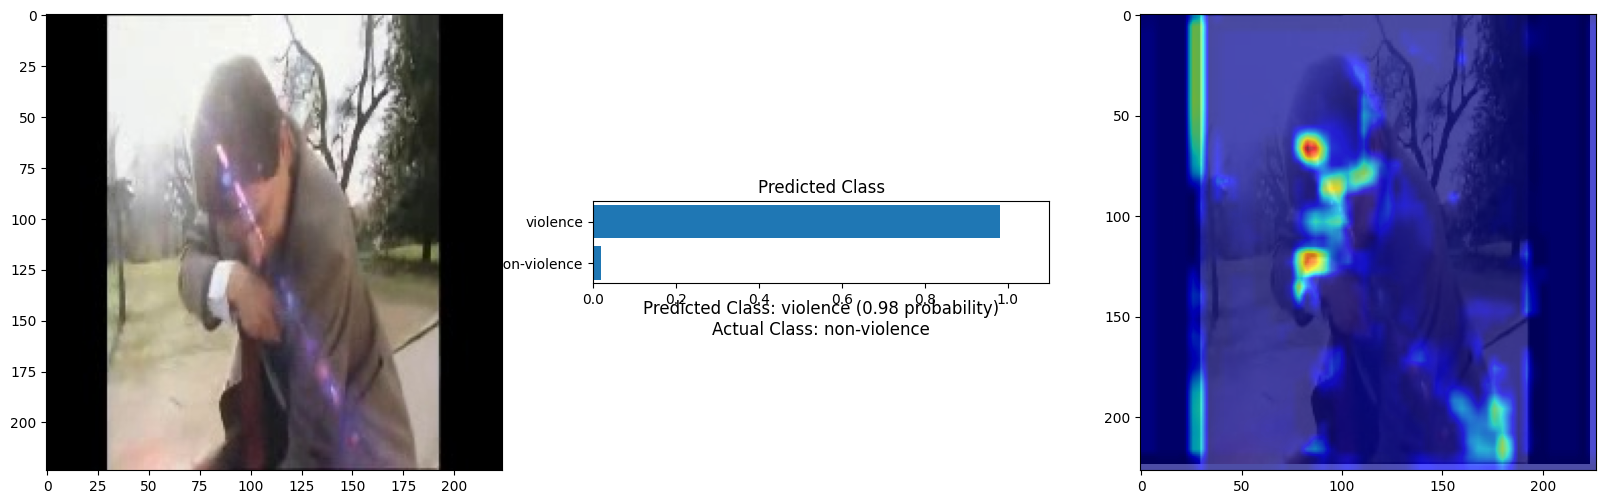

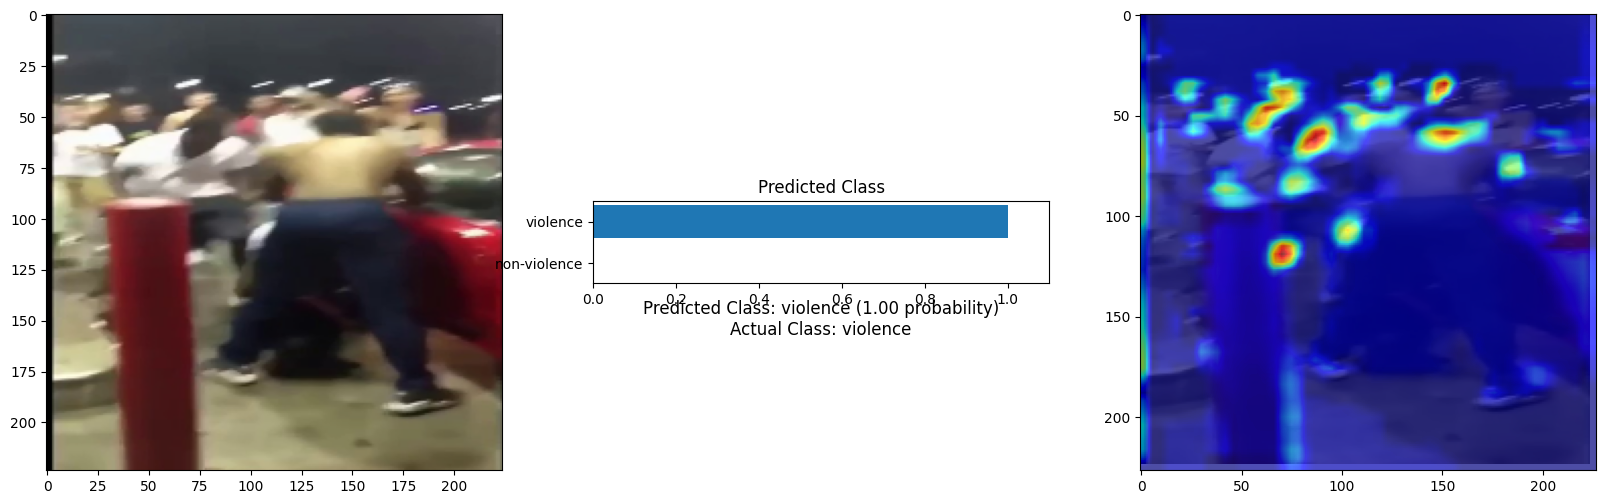

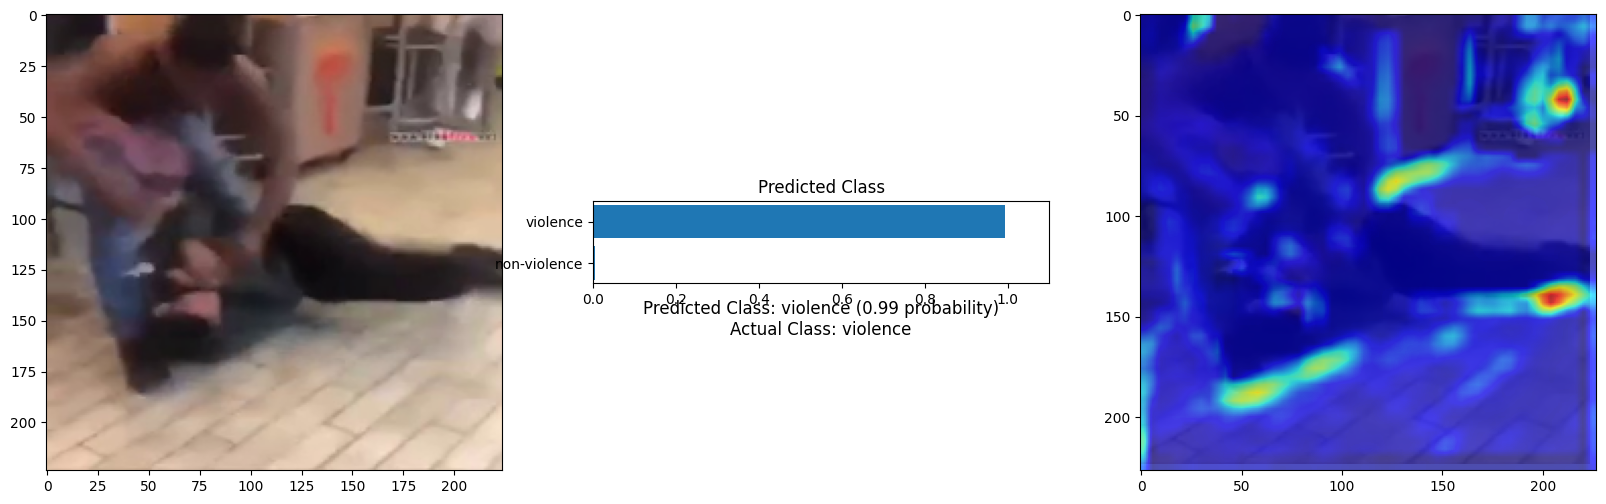

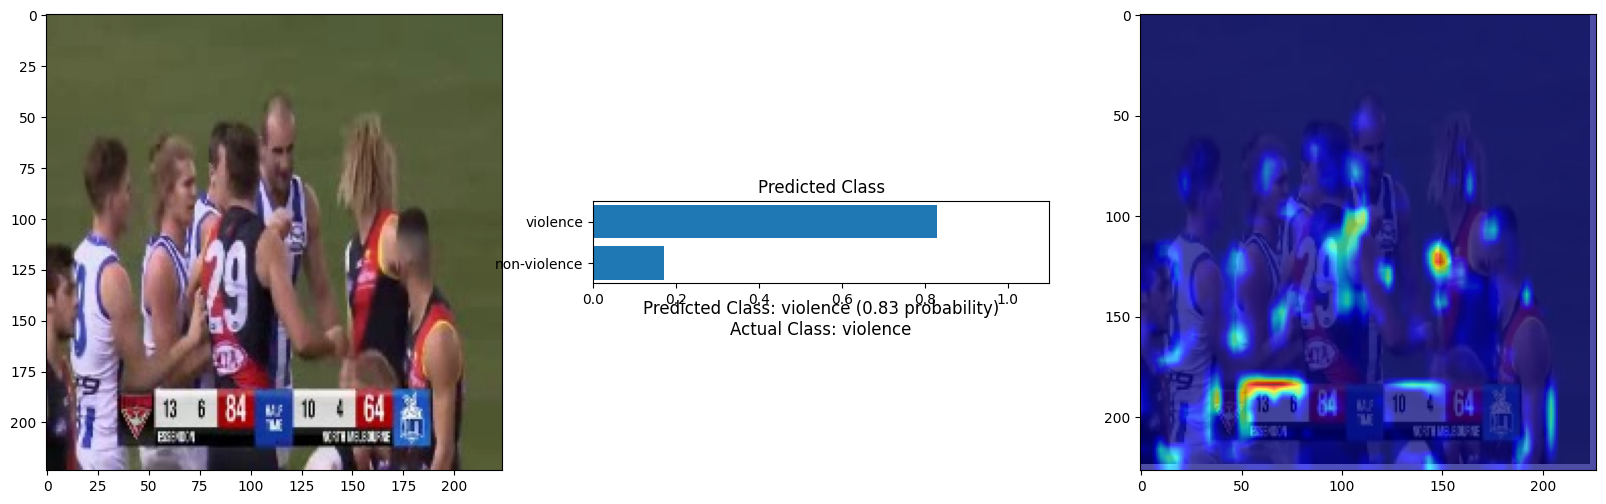

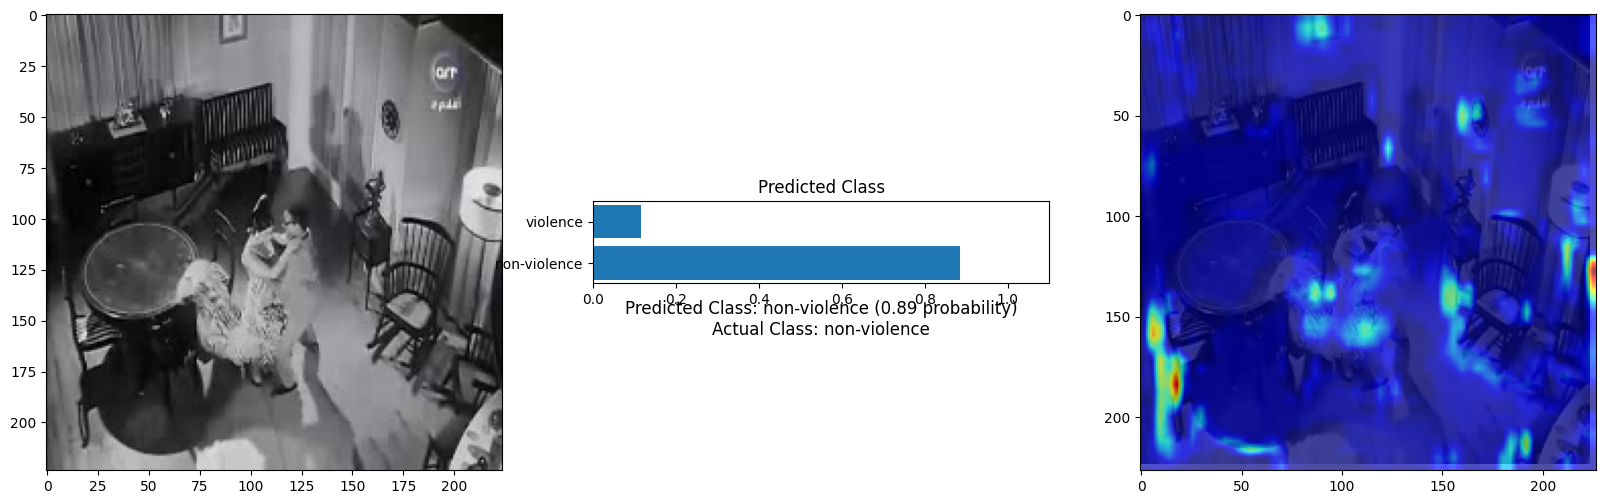

In [ ]:
# Example usage
for i in range(10):
  image, label = validset[i]
  denorm_image = image.permute(1, 2, 0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

  image = image.unsqueeze(0).to(DEVICE)

  pred = model(image)
  heatmap = get_gradcam(model, image, size=227)
  plot_heatmap(denorm_image, pred, heatmap,label)

In [ ]:
def count_parameters(model):
    """
    Count the number of trainable parameters in a model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage with your model
model = CNNModel().to(DEVICE)
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 1143362


In [ ]:
import cv2
import requests
from PIL import Image
from io import BytesIO
import torch

from torchvision import transforms

# Video file path and Telegram bot details
VIDEO_PATH = '/content/V_2.mp4'
BOT_TOKEN = '7779836665:AAFJ8HuswsR9tWSVkmXkQjCkE1u4tyEuodk'
CHAT_ID = '-4583289496'

def send_images_to_telegram(original, heatmap):
    """
    Send the original and heatmap images to a Telegram chat using a bot.

    Parameters:
    - original (PIL Image): The original frame image.
    - heatmap (PIL Image): The heatmap image.
    """
    # Combine original and heatmap images
    combined_image = Image.new('RGB', (original.width + heatmap.width, max(original.height, heatmap.height)))
    combined_image.paste(original, (0, 0))
    combined_image.paste(heatmap, (original.width, 0))

    # Convert the combined image to bytes
    buffer = BytesIO()
    combined_image.save(buffer, format="JPEG")
    buffer.seek(0)

    # Send the combined image
    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendPhoto"
    files = {'photo': buffer}
    data = {'chat_id': CHAT_ID, 'caption': 'Violent activity detected'}
    response = requests.post(url, files=files, data=data)
    print("Combined image sent to Telegram:", response.status_code == 200)

# Process video
cap = cv2.VideoCapture(VIDEO_PATH)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized_frame = cv2.resize(frame_rgb, (224, 224))
    tensor_frame = transforms.ToTensor()(resized_frame).unsqueeze(0).to("cpu")

    # Predict using the model
    with torch.enable_grad():
        prediction = model(tensor_frame)
        predicted_class = torch.argmax(prediction, dim=1).item()

    # If violence is detected, generate heatmap and send to Telegram
    if predicted_class == 1:  # Class 1 for 'violence'
        heatmap = get_gradcam(model, tensor_frame, size=224)
        denorm_frame = resized_frame * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
        plot_heatmap(denorm_frame, prediction, heatmap, actual_label=1)

        # Convert frames to images for Telegram
        original_image = Image.fromarray(frame_rgb)
        heatmap_image = Image.fromarray((heatmap * 255).astype(np.uint8))

        # Send combined original frame and heatmap to Telegram
        send_images_to_telegram(original_image, heatmap_image)
        break

cap.release()
print("Video processing complete.")

Video processing complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms as T
from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

# Paths and Hyperparameters
CSV_FILE = "/content/violence_dataset/image_labels.csv"  # Update as per your dataset
DATA_DIR = "/content/violence_dataset/"  # Update as per your dataset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
LR = 0.001
EPOCHS = 20

# Load dataset and split into training and validation sets
data = pd.read_csv(CSV_FILE)

# Ensure the required columns exist
if 'img_path' not in data.columns or 'label' not in data.columns:
    raise KeyError("CSV file must contain 'img_path' and 'label' columns.")

# Split the dataset
train_df, valid_df = train_test_split(data, test_size=0.15, random_state=42)

# Define Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, augs, data_dir):
        self.dataframe = dataframe
        self.augs = augs
        self.data_dir = data_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.data_dir, row['img_path'])  # Matches 'img_path' column
        label = int(row['label'])

        # Load the image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply augmentations
        if self.augs:
            augmented = self.augs(image=image)
            image = augmented['image']

        # Convert image to PyTorch tensor
        image = T.ToTensor()(image)
        return image, label

# Data Augmentation
train_augs = A.Compose([
    A.Resize(128, 128),  # Original input size
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and data loaders
trainset = ImageDataset(train_df, augs=train_augs, data_dir=DATA_DIR)
validset = ImageDataset(valid_df, augs=valid_augs, data_dir=DATA_DIR)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

# Define Optimized CNN Model with Fine-Tuning
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        self.backbone = models.mobilenet_v2(pretrained=True)

        # Fine-tune the entire model by unfreezing all layers
        for param in self.backbone.features.parameters():
            param.requires_grad = True

        # Replace the classifier with a custom one
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Regularization
            nn.Linear(self.backbone.last_channel, 2)  # Binary classification
        )

    def forward(self, x):
        return self.backbone(x)

# Instantiate the model
model = OptimizedCNN().to(DEVICE)

# Optimizer, Loss Function, and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)  # Fine-tune all layers
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs
criterion = nn.CrossEntropyLoss()

# Training Function
def train_fun(dataloader, model, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct_predictions += (torch.argmax(logits, dim=1) == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / len(dataloader), correct_predictions / total_samples

# Evaluation Function
def eval_fun(dataloader, model, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_actual_labels, all_predicted_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

            all_actual_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

    return total_loss / len(dataloader), correct_predictions / total_samples, all_actual_labels, all_predicted_labels

# Training Loop
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss, train_accuracy = train_fun(trainloader, model, optimizer, criterion)
    valid_loss, valid_accuracy, all_actual_labels, all_predicted_labels = eval_fun(validloader, model, criterion)
    scheduler.step()

    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'best_valid_loss': best_valid_loss
        }, 'optimized_model.pth')
        print("Model saved!")

    # Print results
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

    # Print classification report
    report = classification_report(all_actual_labels, all_predicted_labels, target_names=['non-violence', 'violence'])
    print("\nClassification Report:")
    print(report)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 104MB/s]



Epoch 1/20


100%|██████████| 415/415 [00:07<00:00, 53.19it/s]


Model saved!
Train Loss: 0.5785, Train Accuracy: 0.7248
Valid Loss: 0.5969, Valid Accuracy: 0.7452

Classification Report:
              precision    recall  f1-score   support

non-violence       0.84      0.60      0.70       826
    violence       0.69      0.89      0.78       834

    accuracy                           0.75      1660
   macro avg       0.77      0.74      0.74      1660
weighted avg       0.77      0.75      0.74      1660


Epoch 2/20


100%|██████████| 415/415 [00:07<00:00, 53.27it/s]


Train Loss: 0.5246, Train Accuracy: 0.7593
Valid Loss: 0.7503, Valid Accuracy: 0.6867

Classification Report:
              precision    recall  f1-score   support

non-violence       0.86      0.44      0.58       826
    violence       0.63      0.93      0.75       834

    accuracy                           0.69      1660
   macro avg       0.74      0.69      0.67      1660
weighted avg       0.74      0.69      0.67      1660


Epoch 3/20


100%|██████████| 415/415 [00:07<00:00, 58.44it/s]


Model saved!
Train Loss: 0.5197, Train Accuracy: 0.7594
Valid Loss: 0.3833, Valid Accuracy: 0.8422

Classification Report:
              precision    recall  f1-score   support

non-violence       0.80      0.91      0.85       826
    violence       0.90      0.78      0.83       834

    accuracy                           0.84      1660
   macro avg       0.85      0.84      0.84      1660
weighted avg       0.85      0.84      0.84      1660


Epoch 4/20


100%|██████████| 415/415 [00:07<00:00, 55.02it/s]


Train Loss: 0.4989, Train Accuracy: 0.7737
Valid Loss: 0.4129, Valid Accuracy: 0.8386

Classification Report:
              precision    recall  f1-score   support

non-violence       0.84      0.84      0.84       826
    violence       0.84      0.84      0.84       834

    accuracy                           0.84      1660
   macro avg       0.84      0.84      0.84      1660
weighted avg       0.84      0.84      0.84      1660


Epoch 5/20


100%|██████████| 415/415 [00:06<00:00, 60.16it/s]


Model saved!
Train Loss: 0.4557, Train Accuracy: 0.7975
Valid Loss: 0.3530, Valid Accuracy: 0.8554

Classification Report:
              precision    recall  f1-score   support

non-violence       0.87      0.84      0.85       826
    violence       0.84      0.87      0.86       834

    accuracy                           0.86      1660
   macro avg       0.86      0.86      0.86      1660
weighted avg       0.86      0.86      0.86      1660


Epoch 6/20


100%|██████████| 415/415 [00:06<00:00, 61.98it/s]


Model saved!
Train Loss: 0.3792, Train Accuracy: 0.8376
Valid Loss: 0.2250, Valid Accuracy: 0.9151

Classification Report:
              precision    recall  f1-score   support

non-violence       0.94      0.89      0.91       826
    violence       0.90      0.94      0.92       834

    accuracy                           0.92      1660
   macro avg       0.92      0.91      0.91      1660
weighted avg       0.92      0.92      0.91      1660


Epoch 7/20


100%|██████████| 415/415 [00:06<00:00, 60.97it/s]


Model saved!
Train Loss: 0.3363, Train Accuracy: 0.8595
Valid Loss: 0.1838, Valid Accuracy: 0.9373

Classification Report:
              precision    recall  f1-score   support

non-violence       0.96      0.92      0.94       826
    violence       0.92      0.96      0.94       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 8/20


100%|██████████| 415/415 [00:06<00:00, 61.98it/s]


Train Loss: 0.3273, Train Accuracy: 0.8629
Valid Loss: 0.2003, Valid Accuracy: 0.9259

Classification Report:
              precision    recall  f1-score   support

non-violence       0.96      0.89      0.92       826
    violence       0.90      0.96      0.93       834

    accuracy                           0.93      1660
   macro avg       0.93      0.93      0.93      1660
weighted avg       0.93      0.93      0.93      1660


Epoch 9/20


100%|██████████| 415/415 [00:06<00:00, 60.92it/s]


Model saved!
Train Loss: 0.2944, Train Accuracy: 0.8785
Valid Loss: 0.1618, Valid Accuracy: 0.9416

Classification Report:
              precision    recall  f1-score   support

non-violence       0.97      0.91      0.94       826
    violence       0.92      0.97      0.94       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 10/20


100%|██████████| 415/415 [00:07<00:00, 56.24it/s]


Train Loss: 0.2804, Train Accuracy: 0.8844
Valid Loss: 0.1678, Valid Accuracy: 0.9380

Classification Report:
              precision    recall  f1-score   support

non-violence       0.97      0.90      0.94       826
    violence       0.91      0.97      0.94       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 11/20


100%|██████████| 415/415 [00:07<00:00, 56.02it/s]


Model saved!
Train Loss: 0.2752, Train Accuracy: 0.8832
Valid Loss: 0.1601, Valid Accuracy: 0.9392

Classification Report:
              precision    recall  f1-score   support

non-violence       0.97      0.91      0.94       826
    violence       0.92      0.97      0.94       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 12/20


100%|██████████| 415/415 [00:07<00:00, 55.11it/s]


Model saved!
Train Loss: 0.2558, Train Accuracy: 0.8938
Valid Loss: 0.1562, Valid Accuracy: 0.9386

Classification Report:
              precision    recall  f1-score   support

non-violence       0.97      0.91      0.94       826
    violence       0.91      0.97      0.94       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 13/20


100%|██████████| 415/415 [00:07<00:00, 55.06it/s]


Model saved!
Train Loss: 0.2498, Train Accuracy: 0.8937
Valid Loss: 0.1464, Valid Accuracy: 0.9446

Classification Report:
              precision    recall  f1-score   support

non-violence       0.97      0.92      0.94       826
    violence       0.93      0.97      0.95       834

    accuracy                           0.94      1660
   macro avg       0.95      0.94      0.94      1660
weighted avg       0.95      0.94      0.94      1660


Epoch 14/20


100%|██████████| 415/415 [00:07<00:00, 55.38it/s]


Train Loss: 0.2406, Train Accuracy: 0.9005
Valid Loss: 0.1748, Valid Accuracy: 0.9295

Classification Report:
              precision    recall  f1-score   support

non-violence       0.98      0.88      0.93       826
    violence       0.89      0.98      0.93       834

    accuracy                           0.93      1660
   macro avg       0.93      0.93      0.93      1660
weighted avg       0.93      0.93      0.93      1660


Epoch 15/20


100%|██████████| 415/415 [00:07<00:00, 53.87it/s]


Model saved!
Train Loss: 0.2360, Train Accuracy: 0.9009
Valid Loss: 0.1460, Valid Accuracy: 0.9452

Classification Report:
              precision    recall  f1-score   support

non-violence       0.94      0.95      0.95       826
    violence       0.95      0.94      0.95       834

    accuracy                           0.95      1660
   macro avg       0.95      0.95      0.95      1660
weighted avg       0.95      0.95      0.95      1660


Epoch 16/20


100%|██████████| 415/415 [00:07<00:00, 54.89it/s]


Train Loss: 0.2525, Train Accuracy: 0.8994
Valid Loss: 0.1586, Valid Accuracy: 0.9337

Classification Report:
              precision    recall  f1-score   support

non-violence       0.97      0.89      0.93       826
    violence       0.90      0.97      0.94       834

    accuracy                           0.93      1660
   macro avg       0.94      0.93      0.93      1660
weighted avg       0.94      0.93      0.93      1660


Epoch 17/20


100%|██████████| 415/415 [00:07<00:00, 54.75it/s]


Train Loss: 0.2420, Train Accuracy: 0.9000
Valid Loss: 0.1713, Valid Accuracy: 0.9295

Classification Report:
              precision    recall  f1-score   support

non-violence       0.98      0.88      0.93       826
    violence       0.89      0.98      0.93       834

    accuracy                           0.93      1660
   macro avg       0.93      0.93      0.93      1660
weighted avg       0.93      0.93      0.93      1660


Epoch 18/20


100%|██████████| 415/415 [00:07<00:00, 53.94it/s]


Model saved!
Train Loss: 0.2384, Train Accuracy: 0.9022
Valid Loss: 0.1430, Valid Accuracy: 0.9440

Classification Report:
              precision    recall  f1-score   support

non-violence       0.96      0.93      0.94       826
    violence       0.93      0.96      0.95       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 19/20


100%|██████████| 415/415 [00:07<00:00, 53.97it/s]


Train Loss: 0.2350, Train Accuracy: 0.9036
Valid Loss: 0.1444, Valid Accuracy: 0.9446

Classification Report:
              precision    recall  f1-score   support

non-violence       0.95      0.94      0.94       826
    violence       0.94      0.95      0.94       834

    accuracy                           0.94      1660
   macro avg       0.94      0.94      0.94      1660
weighted avg       0.94      0.94      0.94      1660


Epoch 20/20


100%|██████████| 415/415 [00:07<00:00, 53.03it/s]

Train Loss: 0.2387, Train Accuracy: 0.9042
Valid Loss: 0.1437, Valid Accuracy: 0.9452

Classification Report:
              precision    recall  f1-score   support

non-violence       0.96      0.93      0.94       826
    violence       0.93      0.96      0.95       834

    accuracy                           0.95      1660
   macro avg       0.95      0.95      0.95      1660
weighted avg       0.95      0.95      0.95      1660



In [ ]:
# Evaluate on validation/test dataset
valid_loss, valid_accuracy, all_actual_labels, all_predicted_labels = eval_fun(validloader, model, criterion)

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_actual_labels, all_predicted_labels, target_names=['non-violence', 'violence']))

# Confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

100%|██████████| 415/415 [00:07<00:00, 58.49it/s]

              precision    recall  f1-score   support

non-violence       0.96      0.93      0.94       826
    violence       0.93      0.96      0.95       834

    accuracy                           0.95      1660
   macro avg       0.95      0.95      0.95      1660
weighted avg       0.95      0.95      0.95      1660

Confusion Matrix:
 [[769  57]
 [ 34 800]]


In [ ]:
def count_parameters(model):
    """
    Count the number of trainable parameters in a model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage with your model
model = OptimizedCNN().to(DEVICE)
num_params = count_parameters(model)

In [ ]:
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 2226434
